## Wall functions

Wall functions can *improve* your CFD calculation, but is not a neccesity. It will especially improve the results, if the grid is not finely resolved close the wall.

More specifically, it will improve the prediction of wall shear stress:

$$ \tau_w \equiv \rho \nu \frac{dU}{dy}|_{y=0} ,$$

which will also have an effect on the general flow. I use a positive sign convention (like Pope, but unlinke Aidan).

The velocity variation within in a Finite Volume cell is *always* linear, but this is only true in the viscous sublayer:

<img src="cell_variation.png">

Hence, if the cell centroid is in the log-law region, then the gradient at the wall is underpredicted and therefore $\tau_w$ is underpredicted!

Idea of wall functions: If cell centroid is in log-law region, then use $\nu_w > \nu$, to increase wall shear stress

$$ \tau_w \equiv \rho \nu_w \frac{dU}{dy}|_{y=0} $$

### Derivation of $\nu_w$

First three definitions:

$$ u_\tau \equiv \sqrt{\frac{\tau_w}{\rho}} \quad y^{+} \equiv \frac{y_P u_\tau}{\nu} \quad U^{+} \equiv \frac{U_P}{ u_\tau} $$

The subscript P means evaluated at cell centroid. The first definition can be re-written to:

$$ \begin{aligned} \tau_w &= u_\tau^2 \rho        \\  
                &= \frac{u_\tau U_P \rho}{U^{+}}   \\
   \end{aligned}$$
   
The numerical wall shear stress is:

$$ \tau_w = \rho \nu_w \frac{U_P}{y_P}$$

Equating these two expressions and isolating for $\nu_w$:

$$ \begin{aligned} \nu_w &= \frac{u_\tau y_P}{U^{+}}        \\  
                         &= \boxed{\nu \frac{y^{+}}{U^{+}}}\\
   \end{aligned}$$

For a smooth wall, there exist an universal relation for $U^{+}$, confirmed by experiments and DNS:

$$ U^{+} = \frac{1}{\kappa} \mathrm{log}(E y^{+}) , $$

where $\kappa = 0.4$ and $E = 9.8$. 


### Method 1: Solving the implicit equation

To summarize the above, we use the boxed equation for $\nu_w$ with the universal wall function in the modified, numerical wall shear stress equation:

$$ \tau_w = \rho \nu_w \frac{U_P}{y_P}$$

However, $\tau_w$ appears on both the LHS (obvious) and RHS (not so obvious, through $y^{+}$ in the $\nu_w$ definition). It is an implicit equation! Let's solve this equation at a given iteration with $y_P = 0.05~\mathrm{m}$, $U_P = 0.35~\mathrm{m/s}$, $\rho = 1.225~\mathrm{kg/m}^{3}$ and $\nu = 1.48\cdot10^{-5}~\mathrm{m}^{2}/\mathrm{s}$:

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.optimize import fsolve
mpl.style.use('classic')
# Latex font
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 15
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.numpoints"] = 1
yd = dict(rotation=0,ha='right') # I couldn't find a way to customize these, so use a dict everytime..

yplus from 30.52391563869092 to 167.18637138695723
The tau_w solution is [0.0005823]


(0.0, 0.003)

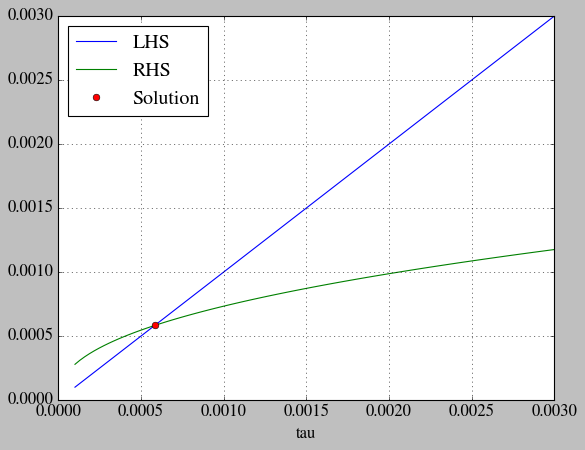

In [65]:
tau_w = np.linspace(10e-5,3*10e-4,100)

U_P = 0.35    # 0.25 m/s
y_P = 0.05    # 5 cm
rho = 1.225   # air
nu = 1.48*10**(-5)  # air
kappa = 0.41  # Value for a smooth wall
E = 9.8       # Value for a smooth wall

u_tau = np.sqrt(tau_w/rho)
yplus = u_tau*y_P/nu
print('yplus from ' + str(yplus[0]) + ' to ' + str(yplus[-1]))
Uplus = 1/kappa*np.log(E*yplus) 
nuw = nu*yplus/Uplus
#print(nuw)
RHS = rho*nuw*U_P/y_P


def f(t,rho=1.225,nu=1.48*10**(-5),y_P=0.05,U_p=0.35,kappa=0.41,E=9.8):
    u_tau = np.sqrt(t/rho)
    yplus = u_tau*y_P/nu
    Uplus = 1/kappa*np.log(E*yplus) 
    nuw = nu*yplus/Uplus
    return rho*nuw*U_P/y_P - t
solution=fsolve(f,0.004)
print('The tau_w solution is ' + str(solution))

fig = plt.figure()
plt.plot(tau_w,tau_w,label='LHS')
plt.plot(tau_w,RHS,label='RHS')
plt.plot(solution,solution,'ro',label='Solution')
plt.xlabel('tau')
plt.grid()
plt.legend(loc='upper left')
plt.xlim(left=0.0)
plt.ylim(bottom=0.0)

We have solved the implicit equation to $\tau_w = 5.8 \cdot 10^{-4}~\mathrm{N}/\mathrm{m}^{2}$. This was visualized as the intersection (Python's fsolve was used to get the precise value). Note, that the RHS curve is not plotted all the way to 0, because the last part is in the viscous sublayer ($U^{+} = y^{+}$, hence the curve flattens out to a constant). The form of the RHS will always resemble $\sim \tau_w^{1/2}$ in the log-law region, because:

$$ RHS \sim \frac{y^{+}}{U^{+}} \sim \frac{\sqrt{\tau_w}}{\mathrm{log}(\sqrt{\tau_w})} $$

It *is* a monotonic increasing function, so a single solution is always expected.

If no wall function had been applied, we would have obtained:

In [11]:
import numpy as np
U_P = 0.35
y_P = 0.05
rho = 1.225
nu = 1.48e-5
tau_w = rho*nu*U_P/y_P
u_tau = np.sqrt(tau_w/rho)
yplus = y_P*u_tau/nu

print('tau_w = %.2e (without wall function)'%(tau_w))
print('yplus = %.1f (without wall function)'%(yplus))


### With wall function
tau_w2 = 5.8e-4
u_tau2 = np.sqrt(tau_w2/rho)
yplus2 = y_P*u_tau2/nu

print(' ')
print('tau_w = %.2e (with wall function)'%(tau_w2))
print('yplus = %.1f (with wall function)'%(yplus2))


tau_w = 1.27e-04 (without wall function)
yplus = 34.4 (without wall function)
 
tau_w = 5.80e-04 (with wall function)
yplus = 73.5 (with wall function)


Wall shear stress without wall function was more than four times lower!

### Method 2: Use information from previous iteration

Instead of solving the implicit equation, we could instead use $\tau_w$ from the previous iteration on the RHS. Then we simply evaluate the RHS to obtain the new $\tau_w$. It seems that this method is more popular than method 1.

### Log-law or viscous sublayer?

The above procedures used the log-law wall function and luckily $30.5 < y^{+} < 167.2$ in the region investigated. A more general approach would use one of the following relations for $U^{+}$:

$$ U^{+} = \begin{cases} y^{+} \quad \quad \quad \quad \mathrm{if} y^{+} < 11.25 \\
                         \frac{1}{\kappa} \mathrm{log}(E y^{+}) \quad \mathrm{if} y^{+} > 11.25 \end{cases} ,$$

or

$$ U^{+} =$$

The value $y^{+} = 11.25$ is chosen in the first expression to have a continuous curve. The second expression is called Spalding's function.

It is interesting to re-write the numerical wall shear stress formula:


$$ \begin{aligned} \tau_w &= \rho \nu_w \frac{U_P}{y_P}        \\  
                &= \rho \nu \frac{y^{+}}{U^{+}} \frac{U_P}{y_P}   \\
                &= \underbrace{\rho \nu  \frac{U_P}{y_P}}_{\tau_{standard}} \cdot \frac{y^{+}}{U^{+}}
   \end{aligned}$$
   
Note that, $\frac{y^{+}}{U^{+}} \geq 1$, hence the wall shear stress is "boosted" in the log-law.

Text(0, 0.5, '$y^{+}/U^{+}$')

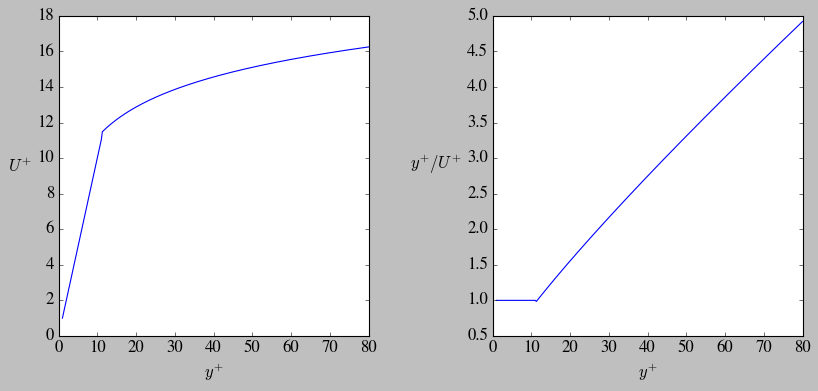

In [35]:
fig, ax = plt.subplots(1,2,sharex=True,figsize=(12,5))
plt.subplots_adjust(wspace=0.4)

yplus = np.linspace(1,80,300)
kappa = 0.41
E = 9.8

Uplus2 = (yplus < 11.25)*yplus + (yplus > 11.25)*1/kappa*np.log(E*yplus)
Uplus_Spalding = 42

ax[0].plot(yplus,Uplus2,label='2-layer formula')
ax[0].set_xlabel(r'$y^{+}$')
ax[0].set_ylabel(r'$U^{+}$',yd)

ax[1].plot(yplus,yplus/Uplus2,label='2-layer formula')
ax[1].set_xlabel(r'$y^{+}$')
ax[1].set_ylabel(r'$y^{+}/U^{+}$',yd)

### Non-smooth surfaces

All the above relations assume a perfectly smooth wall, i.e. with no roughness elements. What happens if this is not the case?


### Temperature wall function

Based on $y^*$ (which Aidan says is calculated using $k$ from the previous iteration) instead of  $y^+$.